In [0]:
# Import Python 3 print function
from __future__ import print_function

# Import OGR - 
from osgeo import ogr

# Open the dataset from the file
dataset = ogr.Open('/content/Training.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')

In [0]:
dataset

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x7f320832e0f0> >

In [0]:
!pip install pyshp

     |████████████████████████████████| 225kB 4.9MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32607 sha256=52f22fd45e5c671199281554ad7d03d8d2ee78aeb04c7ddd143726f6dec76c0b
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
%%bash
# Remember -- "%bash" as seen above just indicates to the IPython notebook that I'm now writing in Bash

# Print out metadata about raster -- we include "-proj4" to print out the Proj4 projection string
gdalinfo /content/fcc_clipped.tif

Driver: GTiff/GeoTIFF
Files: /content/fcc_clipped.tif
Size is 482, 445
Coordinate System is:
PROJCS["WGS 84 / UTM zone 43N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",75],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32643"]]
Origin = (749060.000000000000000,3169480.000000000000000)
Pixel Size = (10.000000000000000,-10.000000000000000)
Metadata:
  AREA_OR_POINT=Ar

In [2]:
driver = dataset.GetDriver()
print('Dataset driver is: {n}\n'.format(n=driver.name))
layer_count = dataset.GetLayerCount()
print('The shapefile has {n} layer(s)\n'.format(n=layer_count))

### What is the name of the 1 layer?
layer = dataset.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))

### What is the layer's geometry? is it a point? a polyline? a polygon?
# First read in the geometry - but this is the enumerated type's value
geometry = layer.GetGeomType()
print(geometry)
# So we need to translate it to the name of the enum
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: Training

3
The layer's geometry is: Polygon

Layer projection is: +proj=longlat +datum=WGS84 +no_defs 

Layer has 28 features

Layer has 2 fields
Their names are: 
	id - Integer64
	crop_name - String


In [3]:
layer

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7f27442af120> >

In [4]:
%%bash

# Print out the usage
gdal_rasterize --help

Usage: gdal_rasterize [-b band]* [-i] [-at]
       {[-burn value]* | [-a attribute_name] | [-3d]} [-add]
       [-l layername]* [-where expression] [-sql select_statement]
       [-dialect dialect] [-of format] [-a_srs srs_def]
       [-co "NAME=VALUE"]* [-a_nodata value] [-init value]*
       [-te xmin ymin xmax ymax] [-tr xres yres] [-tap] [-ts width height]
       [-ot {Byte/Int16/UInt16/UInt32/Int32/Float32/Float64/
             CInt16/CInt32/CFloat32/CFloat64}] [-q]
       <src_datasource> <dst_filename>


In [5]:
%%bash

# Explanation of switches:
# -a ==> write values from the"id" attribute of the shapefile
# -layer ==> the layer name of our shapefile
# -of ==> Output raster file format
# -a_srs ==> output spatial reference system string
# -a_nodata ==> NODATA value for output raster
# -te ==> target extent which matches the raster we want to create the ROI image for
# -tr ==> target resolution, 30 x 30m
# -ot Byte ==> Since we only have values 0 - 5, a Byte datatype is enough

gdal_rasterize -a "id" \
    -l Training \
    -of "GTiff" \
    -a_srs "+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs" \
    -a_nodata 0 \
    -te 462405 1734315 469905 1741815 \
    -tr 30 30 \
    -ot Byte \
     /content/Training.shp /content/Training.gtif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [6]:
# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open('/content/fcc_clipped.tif', gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('/content/Training.gtif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=id']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


In [7]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open('/content/Training.gtif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 211978 pixels
Class 1 contains 1105 pixels
Class 2 contains 572 pixels
Class 3 contains 609 pixels
Class 4 contains 151 pixels
Class 5 contains 75 pixels


0
1
2


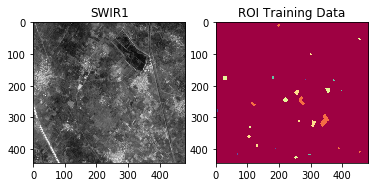

In [8]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('/content/fcc_clipped.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/Training.gtif', gdal.GA_ReadOnly)
#test_di=gdal.Open('/content/Training.gtif', gdal.GA_ReadOnly)
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    print(b)
  
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
#toi = test_di.GetRasterBand(1).ReadAsArray().astype(np.uint8)
# Display them
plt.subplot(121)
plt.imshow(img[:, :, 2], cmap=plt.cm.Greys_r)
#plt.imshow(img[:, :, 2])
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [9]:



img

array([[[2299., 1216., 1402.],
        [2205., 1161., 1391.],
        [2202., 1136., 1380.],
        ...,
        [2361., 1087., 1351.],
        [2473., 1088., 1365.],
        [2310., 1090., 1340.]],

       [[2338., 1162., 1362.],
        [2160., 1143., 1364.],
        [2169., 1128., 1369.],
        ...,
        [2270., 1077., 1346.],
        [2372., 1088., 1370.],
        [2309., 1123., 1376.]],

       [[2409., 1129., 1377.],
        [2328., 1109., 1361.],
        [2355., 1113., 1368.],
        ...,
        [2191., 1067., 1350.],
        [2247., 1098., 1356.],
        [2269., 1140., 1387.]],

       ...,

       [[2335., 1191., 1394.],
        [2281., 1218., 1410.],
        [2246., 1239., 1386.],
        ...,
        [2232., 1162., 1388.],
        [2193., 1175., 1367.],
        [2242., 1165., 1388.]],

       [[2394., 1178., 1376.],
        [2283., 1211., 1389.],
        [2189., 1213., 1387.],
        ...,
        [2265., 1149., 1380.],
        [2188., 1156., 1375.],
        [2189.,

In [10]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]
#z = img[toi > 0]
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 2] <= 1
#clear = z[:, 2] <=1
#X = X[clear, :2]  # we can ditch the Fmask band now
#y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
#print('After masking, our z array is sized: {sz}'.format(sz=z.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 2512 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (2512, 3)
Our y array is sized: (2512,)
After masking, our X matrix is sized: (2512, 3)
After masking, our y array is sized: (2512,)


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [12]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 89.45063694267516%


In [14]:
bands = [1, 2, 3]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.3006853725942862
Band 2 importance: 0.33197369129663934
Band 3 importance: 0.3673409361090745


In [15]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1    2    3    4   5   All
truth                                 
1        1105    0    0    0   0  1105
2           0  572    0    0   0   572
3           0    0  609    0   0   609
4           0    0    0  151   0   151
5           0    0    0    0  75    75
All      1105  572  609  151  75  2512


In [16]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] )

img_as_array = img[:, :, :3].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (445, 482, 3) to (214490, 3)


In [17]:
img[:,:,:]

array([[[2299., 1216., 1402.],
        [2205., 1161., 1391.],
        [2202., 1136., 1380.],
        ...,
        [2361., 1087., 1351.],
        [2473., 1088., 1365.],
        [2310., 1090., 1340.]],

       [[2338., 1162., 1362.],
        [2160., 1143., 1364.],
        [2169., 1128., 1369.],
        ...,
        [2270., 1077., 1346.],
        [2372., 1088., 1370.],
        [2309., 1123., 1376.]],

       [[2409., 1129., 1377.],
        [2328., 1109., 1361.],
        [2355., 1113., 1368.],
        ...,
        [2191., 1067., 1350.],
        [2247., 1098., 1356.],
        [2269., 1140., 1387.]],

       ...,

       [[2335., 1191., 1394.],
        [2281., 1218., 1410.],
        [2246., 1239., 1386.],
        ...,
        [2232., 1162., 1388.],
        [2193., 1175., 1367.],
        [2242., 1165., 1388.]],

       [[2394., 1178., 1376.],
        [2283., 1211., 1389.],
        [2189., 1213., 1387.],
        ...,
        [2265., 1149., 1380.],
        [2188., 1156., 1375.],
        [2189.,

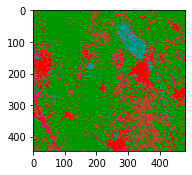

In [18]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]
    #print('---',colors[:,:,:],'---')
    # Enforce maximum and minimum values
    colors[colors[:, :, :] >= max_val] = 255
    colors[colors[:, :, :] < min_val] = 0
    print(colors,'--->')
    for b in range(colors.shape[2]):#[0,1,2]
        colors[:, :, b] = colors[:, :, b] * 1 / 255

    return colors
    
#img543 = color_stretch(img, [0,1,2], (111,111))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (160, 82, 45, 255)),  # bare land
    (2, (0,150, 0, 255)),  # crop land
    (3, (250, 0, 0, 255)),  # buit up
    (4, (0,150, 150, 255)),  # water body
    (5, (250, 0, 150, 255))  # Road
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n+1)]
cmap = plt.matplotlib.colors.ListedColormap((index_colors), n)

# Now show the classmap next to the image

#plt.subplot(121)
#plt.imshow(img543)
 
plt.subplot(121)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

#plt.subplot(122)
#plt.imshow(img)
#plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


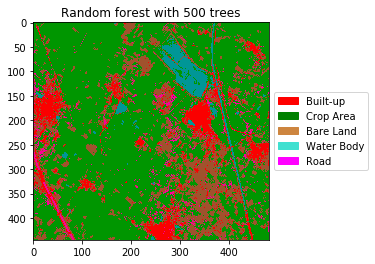

In [19]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Built-up')
Green_patch = mpatches.Patch(color='g', label='Crop Area')
blue_patch = mpatches.Patch(color='turquoise', label='Water Body')
brown_patch = mpatches.Patch(color='peru', label='Bare Land')
pink_patch = mpatches.Patch(color='magenta', label='Road')
plt.legend(handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])
ax=plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])


plt.title("Random forest with 500 trees")
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


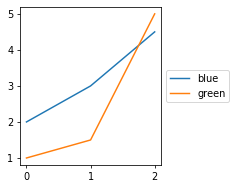

In [20]:
import matplotlib.pyplot as plt
w = 4
h = 3
d = 70
plt.figure(figsize=(w, h), dpi=d)
y1 = [2, 3, 4.5]
y2 = [1, 1.5, 5]

plt.plot(y1)
plt.plot(y2)
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5
plt.legend(["blue", "green"], loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.savefig("out.png")

Text(0.5, 1.0, 'ROI Training Data')

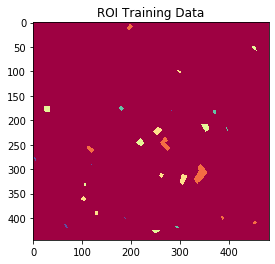

In [21]:
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')


In [0]:
import cv2

In [23]:


import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline

# Data dir


# Filepath
fp = os.path.join('/content/fcc_clipped.tif')

# Open the file:
raster = rasterio.open(fp)

# Plot band 1
show((raster, 1))

ModuleNotFoundError: ignored

In [0]:
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

NameError: ignored

In [0]:
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

NameError: ignored

In [0]:
nir = raster.read(1)
red = raster.read(2)
green = raster.read(3)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

NameError: ignored

NameError: ignored

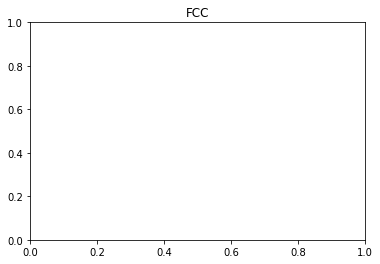

In [0]:
plt.title("FCC")
plt.imshow(nrg, cmap=cmap, interpolation='none')
plt.show()

In [0]:
!pip install rasterio


     |████████████████████████████████| 15.2MB 156kB/s 


In [0]:
from sklearn.svm import SVC # "Support Vector Classifier" 
svm = SVC(kernel='linear') 
  
# fitting x samples and y classes 
svm.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:

svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = svm.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1    2    3    4   5   All
truth                                 
1        1026   29   50    0   0  1105
2          26  540    6    0   0   572
3         110    3  493    0   3   609
4           0    0    0  151   0   151
5           4   12   18    0  41    75
All      1166  584  567  151  44  2512


In [0]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] )

img_as_array = img[:, :, :3].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = svm.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (445, 482, 3) to (214490, 3)


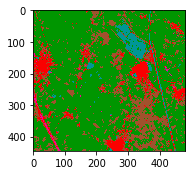

In [0]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]
    #print('---',colors[:,:,:],'---')
    # Enforce maximum and minimum values
    colors[colors[:, :, :] >= max_val] = 255
    colors[colors[:, :, :] < min_val] = 0
    print(colors,'--->')
    for b in range(colors.shape[2]):#[0,1,2]
        colors[:, :, b] = colors[:, :, b] * 1 / 255

    return colors
    
#img543 = color_stretch(img, [0,1,2], (111,111))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (160, 82, 45, 255)),  # bare land
    (2, (0,150, 0, 255)),  # crop land
    (3, (250, 0, 0, 255)),  # buit up
    (4, (0,150, 150, 255)),  # water body
    (5, (250, 0, 150, 255))  # Road
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n+1)]
cmap = plt.matplotlib.colors.ListedColormap((index_colors), n)

# Now show the classmap next to the image

#plt.subplot(121)
#plt.imshow(img543)
 
plt.subplot(121)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

#plt.subplot(122)
#plt.imshow(img)
#plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


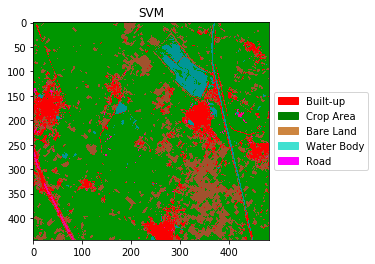

In [0]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Built-up')
Green_patch = mpatches.Patch(color='g', label='Crop Area')
blue_patch = mpatches.Patch(color='turquoise', label='Water Body')
brown_patch = mpatches.Patch(color='peru', label='Bare Land')
pink_patch = mpatches.Patch(color='magenta', label='Road')
plt.legend(handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])
ax=plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])

plt.title("SVM")
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

In [0]:
svm.score(,class_prediction)

ValueError: ignored

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=3, min_samples_leaf=5) 
  
    # Performing training 
clf_gini.fit(X,y) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [0]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = clf_gini.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1    2    3    4   All
truth                             
1        1075   13   17    0  1105
2          41  531    0    0   572
3         270    2  337    0   609
4           0    0    0  151   151
5          57    8   10    0    75
All      1443  554  364  151  2512


In [0]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] )

img_as_array = img[:, :, :3].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = clf_gini.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (445, 482, 3) to (214490, 3)


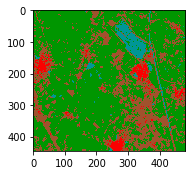

In [0]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]
    #print('---',colors[:,:,:],'---')
    # Enforce maximum and minimum values
    colors[colors[:, :, :] >= max_val] = 255
    colors[colors[:, :, :] < min_val] = 0
    print(colors,'--->')
    for b in range(colors.shape[2]):#[0,1,2]
        colors[:, :, b] = colors[:, :, b] * 1 / 255

    return colors
    
#img543 = color_stretch(img, [0,1,2], (111,111))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (160, 82, 45, 255)),  # bare land
    (2, (0,150, 0, 255)),  # crop land
    (3, (250, 0, 0, 255)),  # buit up
    (4, (0,150, 150, 255)),  # water body
    (5, (250, 0, 150, 255))  # Road
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n+1)]
cmap = plt.matplotlib.colors.ListedColormap((index_colors), n)

# Now show the classmap next to the image

#plt.subplot(121)
#plt.imshow(img543)
 
plt.subplot(121)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

#plt.subplot(122)
#plt.imshow(img)
#plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


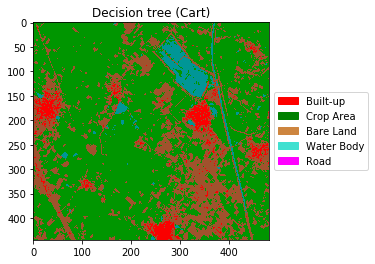

In [0]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Built-up')
Green_patch = mpatches.Patch(color='g', label='Crop Area')
blue_patch = mpatches.Patch(color='turquoise', label='Water Body')
brown_patch = mpatches.Patch(color='peru', label='Bare Land')
pink_patch = mpatches.Patch(color='magenta', label='Road')
plt.legend(handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])
ax=plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])

plt.title("Decision tree (Cart)")
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

In [0]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X,y) 
  

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = gnb.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1    2    3    4    5   All
truth                                  
1         895   42  110    0   58  1105
2          27  545    0    0    0   572
3         223    5  372    0    9   609
4           0    1    0  150    0   151
5          10   12    7    0   46    75
All      1155  605  489  150  113  2512


In [0]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] )

img_as_array = img[:, :, :3].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = gnb.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (445, 482, 3) to (214490, 3)


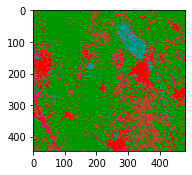

In [24]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]
    #print('---',colors[:,:,:],'---')
    # Enforce maximum and minimum values
    colors[colors[:, :, :] >= max_val] = 255
    colors[colors[:, :, :] < min_val] = 0
    print(colors,'--->')
    for b in range(colors.shape[2]):#[0,1,2]
        colors[:, :, b] = colors[:, :, b] * 1 / 255

    return colors
    
#img543 = color_stretch(img, [0,1,2], (111,111))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (160, 82, 45, 255)),  # bare land
    (2, (0,150, 0, 255)),  # crop land
    (3, (250, 0, 0, 255)),  # buit up
    (4, (0,150, 150, 255)),  # water body
    (5, (250, 0, 150, 255))  # Road
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n+1)]
cmap = plt.matplotlib.colors.ListedColormap((index_colors), n)

# Now show the classmap next to the image

#plt.subplot(121)
#plt.imshow(img543)
 
plt.subplot(121)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

#plt.subplot(122)
#plt.imshow(img)
#plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


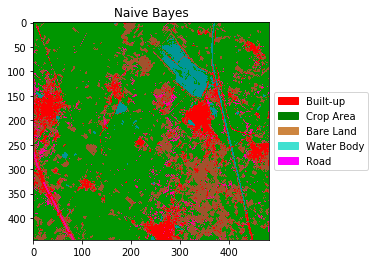

In [25]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Built-up')
Green_patch = mpatches.Patch(color='g', label='Crop Area')
blue_patch = mpatches.Patch(color='turquoise', label='Water Body')
brown_patch = mpatches.Patch(color='peru', label='Bare Land')
pink_patch = mpatches.Patch(color='magenta', label='Road')
plt.legend(handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])
ax=plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[red_patch,Green_patch,brown_patch,blue_patch,pink_patch])

plt.title("Naive Bayes")
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()